<a href="https://colab.research.google.com/github/VaishnaviBairagoni/Natural-Language-Processing-NLP-/blob/main/(NLP-T-28-08-2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q nltk scikit-learn seaborn matplotlib pandas

import os
import re
import string
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Section A: Load and Explore
#Data Exploration
DATA_PATH = '/content/tweets.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Could not find {DATA_PATH}. Put Kaggle train.csv in working dir.")

df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print(df.columns.tolist())

# Quick peek
display(df.head())


Data shape: (11370, 5)
['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0



Label counts:
 target
0    9256
1    2114
Name: count, dtype: int64


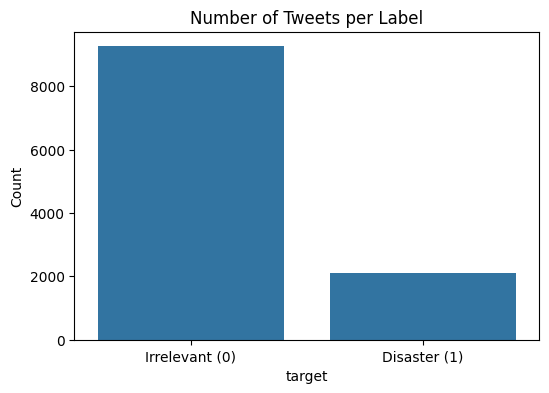

In [3]:
# Q1: Number of tweets per label & bar plot
label_counts = df['target'].value_counts().sort_index()
print("\nLabel counts:\n", label_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0,1], ['Irrelevant (0)','Disaster (1)'])
plt.ylabel('Count')
plt.title('Number of Tweets per Label')
plt.show()


In [4]:
# Show 5 sample tweets from each class
print("\n--- 5 sample Irrelevant tweets (target=0) ---")
display(df[df['target']==0]['text'].sample(5, random_state=42).reset_index(drop=True))

print("\n--- 5 sample Disaster tweets (target=1) ---")
display(df[df['target']==1]['text'].sample(5, random_state=42).reset_index(drop=True))


--- 5 sample Irrelevant tweets (target=0) ---


,text
0,s 1656ABAF :Battle ID I need backup! Lvl 100 C...
1,The place where these children once called hom...
2,i ordered one from @/wonu_hurricane ! good luc...
3,IM DEVASTATED https://t.co/ynVGOzdjuS
4,forgive...Error...Iran...Vow...Punish...All......



--- 5 sample Disaster tweets (target=1) ---


,text
0,#StormBrendan Update-8.00 Tuesday.: Significan...
1,British politicians are quick to call Israel a...
2,1033) British Model Madalyn Davis dies in Sydn...
3,6-Alarm #Fire #BoundBrook #NewJersey Sun Massi...
4,my fatass just tripped on some shit in my room...


In [8]:
#Text Preprocessing Pipeline
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text_to_tokens(text, remove_stopwords=True):
    """
    Cleans tweet text and returns list of alpha tokens (lowercased).
    Steps:
    - remove URLs, mentions, hashtags
    - lowercase
    - tokenize with nltk
    - remove non-alpha tokens and optionally remove stopwords
    """
    if not isinstance(text, str):
        text = ""
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove mentions and hashtags (drop the entire token)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    # Remove punctuation characters like &amp; etc -> keep alpha only tokens later
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # keep only alphabetic tokens
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply cleaning
df['clean_tokens'] = df['text'].apply(clean_text_to_tokens)
df['clean_text'] = df['clean_tokens'].apply(lambda toks: ' '.join(toks))

# Show a few rows with original vs cleaned
display(df[['text','clean_text']].head(7))

# Q3. Stemming vs Lemmatization on 5 sample tweets
sample_originals = df['text'].sample(5, random_state=1).tolist()
comparison = []
for orig in sample_originals:
    toks = clean_text_to_tokens(orig)
    stemmed = [ps.stem(w) for w in toks]
    lemm = [lemmatizer.lemmatize(w) for w in toks]
    comparison.append({
        'original': orig,
        'tokens': ' '.join(toks),
        'stemmed': ' '.join(stemmed),
        'lemmatized': ' '.join(lemm)
    })

compare_df = pd.DataFrame(comparison)
print("\nStemming vs Lemmatization (5 samples):")
display(compare_df)


,text,clean_text
0,"Communal violence in Bhainsa, Telangana. ""Ston...",communal violence bhainsa telangana stones pel...
1,Telangana: Section 144 has been imposed in Bha...,telangana section imposed bhainsa january clas...
2,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
3,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
4,"""Lord Jesus, your love brings freedom and pard...",lord jesus love brings freedom pardon fill hol...
5,"If this child was Chinese, this tweet would ha...",child chinese tweet would gone viral social me...
6,Several houses have been set ablaze in Ngemsib...,several houses set ablaze ngemsibaa village ok...



Stemming vs Lemmatization (5 samples):


,original,tokens,stemmed,lemmatized
0,2 seconds. Why is she singing through her nose...,seconds singing nose trim nose hair first,second sing nose trim nose hair first,second singing nose trim nose hair first
1,"Water being trucked in , watching 7, 30 this i...",water trucked watching looking like biggest on...,water truck watch look like biggest ongo,water trucked watching looking like biggest on...
2,i want some fire ass head.😭,want fire ass,want fire ass,want fire as
3,Joined Premier &amp; Comm Baxter today to visi...,joined premier amp comm baxter today visit ull...,join premier amp comm baxter today visit ullad...,joined premier amp comm baxter today visit ull...
4,"UAE bracing up for heavy rain, hailstorm in UA...",uae bracing heavy rain hailstorm uae,uae brace heavi rain hailstorm uae,uae bracing heavy rain hailstorm uae


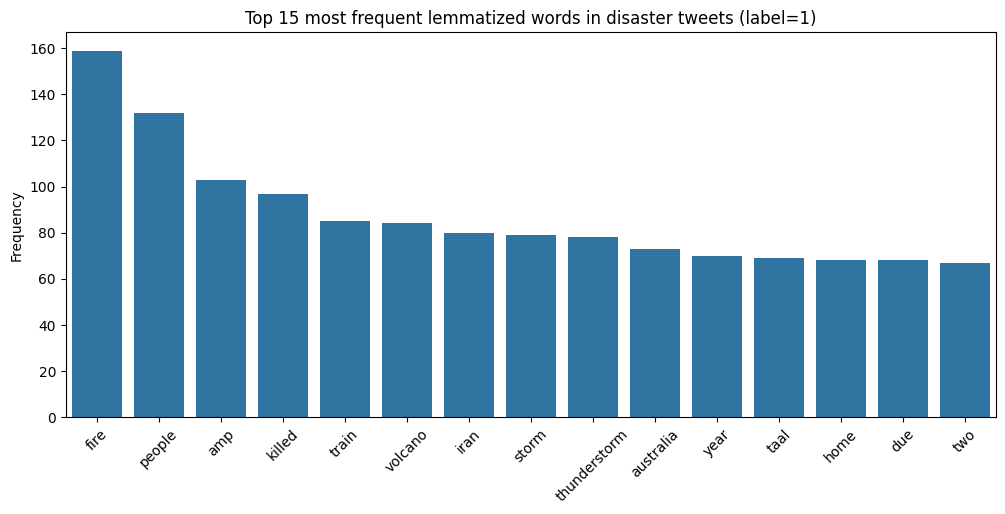

In [9]:
#Analysis and Summary
# Q4: Frequent words in disaster tweets (label==1)
disaster_tokens = df[df['target']==1]['clean_tokens'].explode().dropna().astype(str).tolist()
disaster_lemmatized = [lemmatizer.lemmatize(tok) for tok in disaster_tokens]
freq = Counter(disaster_lemmatized)
top15 = freq.most_common(15)
words, counts = zip(*top15)

plt.figure(figsize=(12,5))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 15 most frequent lemmatized words in disaster tweets (label=1)")
plt.ylabel("Frequency")
plt.show()


Average token count BEFORE preprocessing: 20.78
Average token count AFTER preprocessing:  8.63


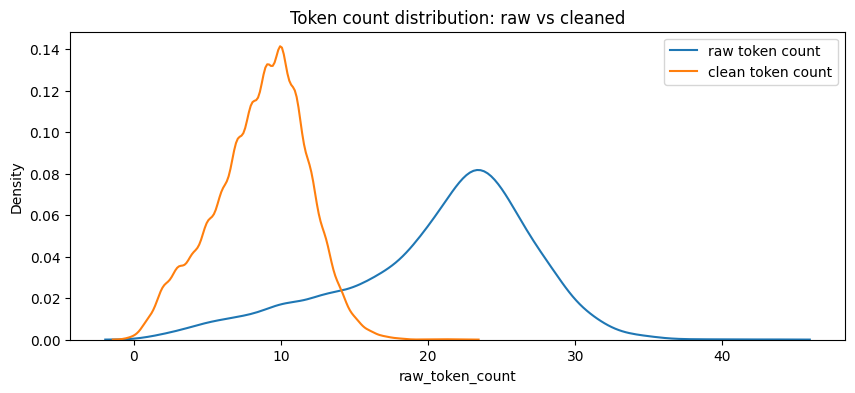


Comment: Preprocessing removes URLs, mentions, hashtags, punctuation, and stopwords —reduces average token count and noise.


In [11]:
# Q5: Tweet length analysis: before and after preprocessing
df['raw_token_count'] = df['text'].apply(lambda t: len(word_tokenize(t)) if isinstance(t, str) else 0)
df['clean_token_count'] = df['clean_tokens'].apply(len)
avg_raw = df['raw_token_count'].mean()
avg_clean = df['clean_token_count'].mean()
print(f"\nAverage token count BEFORE preprocessing: {avg_raw:.2f}")
print(f"Average token count AFTER preprocessing:  {avg_clean:.2f}")

plt.figure(figsize=(10,4))
sns.kdeplot(df['raw_token_count'], label='raw token count')
sns.kdeplot(df['clean_token_count'], label='clean token count')
plt.legend()
plt.title('Token count distribution: raw vs cleaned')
plt.show()

print("\nComment: Preprocessing removes URLs, mentions, hashtags, punctuation, and stopwords —reduces average token count and noise.")




In [12]:
#Machine Learning Model
# Q6. TF-IDF representation (use cleaned text)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'].fillna(''))
y = df['target'].values

print("\nTF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (11370, 5000)


In [14]:
# Q7. Train/test split & model training
RND = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)

model = LogisticRegression(max_iter=1000, random_state=RND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n--- Model Performance (Test Set) ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



--- Model Performance (Test Set) ---
Accuracy : 0.8681
Precision: 0.8514
Recall   : 0.3522
F1-score : 0.4983

Classification Report:
              precision    recall  f1-score   support

           0     0.8695    0.9860    0.9241      1851
           1     0.8514    0.3522    0.4983       423

    accuracy                         0.8681      2274
   macro avg     0.8604    0.6691    0.7112      2274
weighted avg     0.8661    0.8681    0.8449      2274



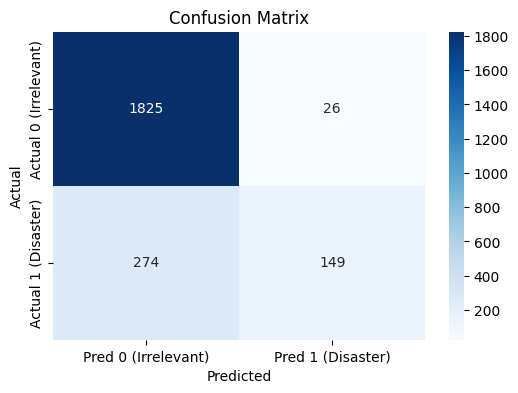

In [17]:
# Q8. Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (Irrelevant)','Pred 1 (Disaster)'],
            yticklabels=['Actual 0 (Irrelevant)','Actual 1 (Disaster)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [18]:
# Short discussion printed
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix counts: TN, FP, FN, TP =", (tn, fp, fn, tp))
print("\nDiscussion (short):")
print("- Usually the Disaster class (1) is harder to classify because it is less frequent and wording is noisy/ambiguous.")
print("- False positives (irrelevant -> predicted disaster) happen when casual tweets contain keywords like 'fire', 'storm', 'flood' out of context.")
print("- Consider improvements: more powerful text representations (word embeddings, BERT), class weighting, more aggressive cleaning, or adding features (hashtags, presence of URLs, uppercase ratio).")


Confusion matrix counts: TN, FP, FN, TP = (np.int64(1825), np.int64(26), np.int64(274), np.int64(149))

Discussion (short):
- Usually the Disaster class (1) is harder to classify because it is less frequent and wording is noisy/ambiguous.
- False positives (irrelevant -> predicted disaster) happen when casual tweets contain keywords like 'fire', 'storm', 'flood' out of context.
- Consider improvements: more powerful text representations (word embeddings, BERT), class weighting, more aggressive cleaning, or adding features (hashtags, presence of URLs, uppercase ratio).
